In [102]:
# import tabulate
# print(tabulate.tabulate([[f'{s}' for s in ['0.20','0.20','0.20','0.20','0.20']]], disable_numparse=True, tablefmt='simple_grid'))
# print(tabulate.tabulate([[f'{s:4}' for s in rain[:20].astype(int).astype(str)]], tablefmt='simple_grid'))
# print(tabulate.tabulate([[f'{s:4}' for s in np.convolve(rain[:20], np.ones(5)/5, mode='valid').astype(str)]], tablefmt='simple_grid'))

# 04_04: Smoothing and plotting time series

In [7]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

So we know how to load temperature data for any station, how to compute basic summaries such as mean, min, and max, and how to integrate missing data points using interpolation. Here's the code we need.

In [2]:
import getweather

def fillnans(array):
    x = np.arange(len(array))
    good = ~np.isnan(array)

    return np.interp(x, x[good], array[good])

In the last video, we looked at data for Pasadena; let's move to even sunnier skies now, by looking at weather in the town of Hilo, in Big Island, Hawaii. We use our custom loader.

In [5]:
hilo = getweather.getyear('HILO', ['TMIN','TMAX'], 2000)

...and we fill the missing data for both TMIN and TMAX columns. Once more, tuple unpacking is very useful.

In [10]:
hilo['TMIN'], hilo['TMAX'] = fillnans(hilo['TMIN']), fillnans(hilo['TMAX'])

To summarize the data, we obtain the yearly average, which gives us a sense of the typical value for TMIN, and the min and max, which span the range of variation of these measurements.

In [11]:
np.mean(hilo['TMIN']), np.min(hilo['TMIN']), np.max(hilo['TMIN'])

(19.102739726027398, 14.4, 23.3)

We can plot these values on top of the time series. The matplotlib function `axhline` (for "axes/horizontal line") plots a horizontal line that spans the entire graph---just what we need.

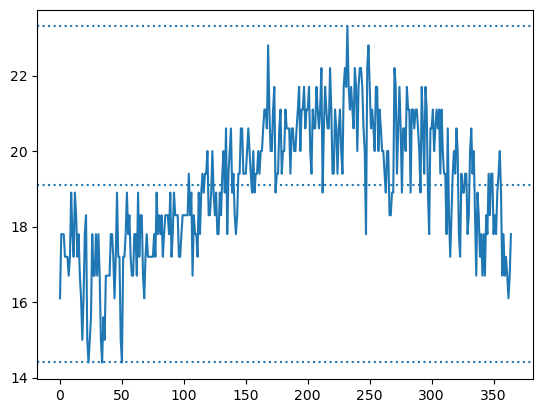

In [15]:
pp.plot(hilo['TMIN'])

# we loop over a list of functions!
for summary in [np.mean, np.min, np.max]:
    pp.axhline(summary(hilo['TMIN']), linestyle=':') # dotted line

Another common way to measure the range of variation of a time series is to compute the standard deviation, defined as the square root of the variance. If you need a refresher about it, wikipedia will help.

In [16]:
mean, err = np.mean(hilo['TMIN']), math.sqrt(np.var(hilo['TMIN']))

We then plot the time series, the mean, and values one standard deviation above and below the mean. _Most of the time_, the temperatures are included in this range.

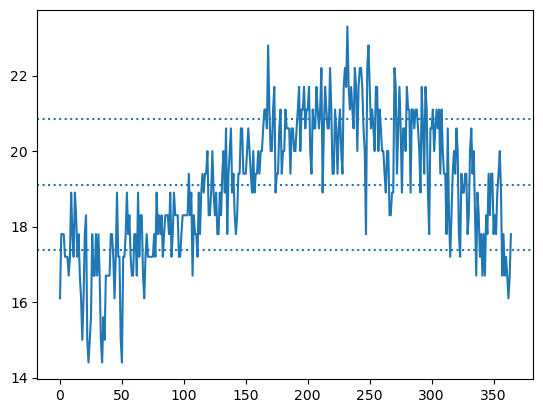

In [17]:
pp.plot(hilo['TMIN'])

for value in [mean, mean - err, mean + err]:
    pp.axhline(value, linestyle=':')

Given that this is Hawaii, it's also interesting to look at precipitation. The rainy season, which starts in November, is evident.

In [20]:
rain = fillnans(getweather.getyear('HILO', ['PRCP'], 2000)['PRCP'])

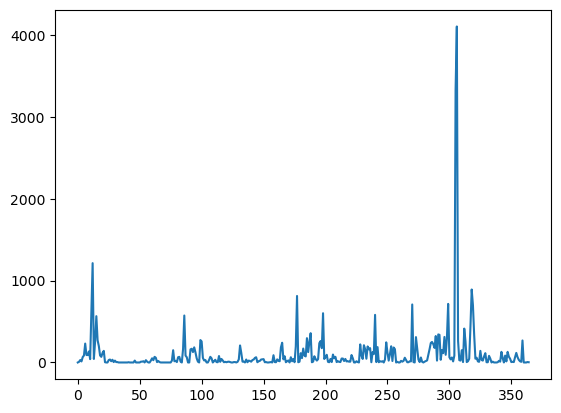

In [21]:
pp.plot(rain)

Looking at the data this way is very informative, but we also see a lot of noise and rapid variations between one day and the next, which can obscure underlying trends. To remove the noise, we can _smooth_ the data so that it we see the slower long-term behavior below the oscillations.

The simplest approach to smoothing is replacing each value with the average of a set of its neighbors (including itself).

With NumPy, we do so with `np.convolve`, which slides a mask across a vector, multiplying the elements of the mask with the elements of the vector and summing them up.

We'll use a very simple constant mask, normalized so that it sums to one. If you think about it, the result is a vector shorter than the original.

Let's try it out... we'll plot the original temperature series as dots (I want them smaller), and the smoothed series as continuous line. This works fine, we are reducing the quick oscillations, while emphasizing the underlying, slower trend.

By specifying that the convolution mode is `'valid'` we are accepting that the result is indeed a shorter vector.

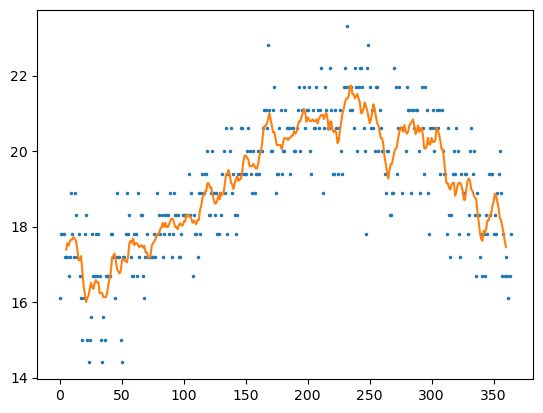

In [150]:
pp.plot(hilo['TMIN'], '.', ms=3) # smaller dots
pp.plot(range(5, 361), np.convolve(hilo['TMIN'], mask, mode='valid')) # align shorter vector

By contrast, if the mode is `'same'` we get a full output vector, but observe anomalies at the beginning and the end; as the mask slides over the boundary of the data, it effectively multiplies zeros.

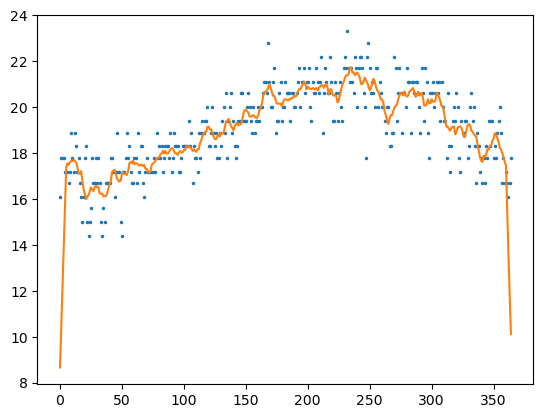

In [151]:
pp.plot(hilo['TMIN'], '.', ms=3)
pp.plot(np.convolve(hilo['TMIN'], mask, mode='same'))

With a little more work, we could pad the data at the boundaries using measurements from the previous and following year. But for simplicity we'll just use shorter time series.

Here's a function that performs the smoothing with a constant mask of arbitrary length.


In [140]:
def smooth(array, window=10, mode='valid'):
    return np.convolve(array, np.ones(window)/window, mode)

We plot TMIN and TMAX together for Hilo:

In [154]:
len(smooth(hilo['TMIN'], 10))

356

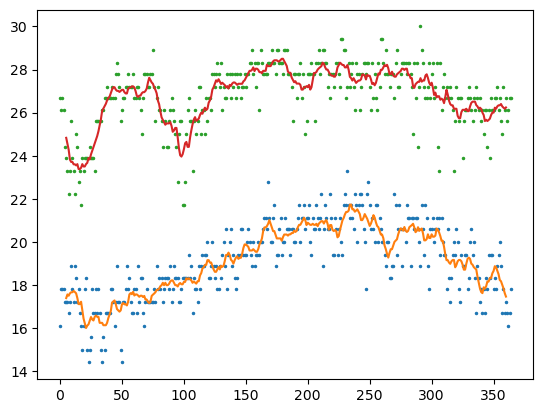

In [156]:
pp.plot(hilo['TMIN'], '.', ms=3)
pp.plot(range(5, 361), smooth(hilo['TMIN'], 10))

pp.plot(hilo['TMAX'], '.', ms=3)
pp.plot(range(5, 361), smooth(hilo['TMAX'], 10))

This is an interesting plot---I'd like to see it for other cities!

We take our code it and generalize it to a function. Get the data, and for both TMIN and TMAX we fill missing values, smooth the data, and plot it. We also add a title and reasonable axis limits.

In [222]:
def plotsmoothed(station, year):
    # get the data
    stationdata = getweather.getyear(station, ['TMIN','TMAX'], year)

    # repeat for TMIN and TMAX
    for obs in ['TMIN','TMAX']:   
        # fill NaNs and smooth
        data = smooth(fillnans(stationdata[obs]), 20)
        # plot, setting x to the post-smoothing range
        pp.plot(range(10, 356), data)

    # add title and set axes limits
    pp.title(station)
    pp.axis(xmin=1, xmax=365, ymin=-10, ymax=45)

Let me try this out... we can try multiple years to see if the Hawaii climate is stable. In fact for such nice weather we don't need the entire y range. 

(1.0, 365.0, 15.0, 32.0)

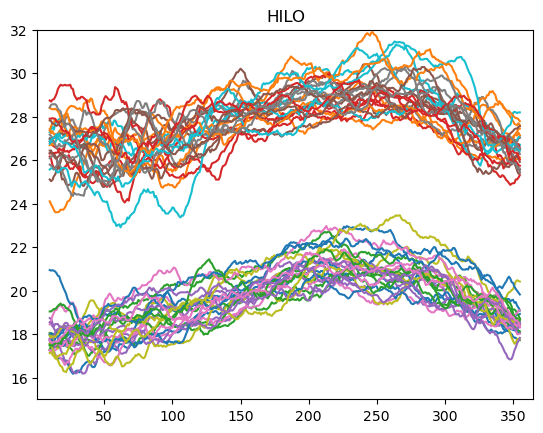

In [223]:
for year in range(2000, 2024):
    plotsmoothed('HILO', year)

pp.axis(ymin=15, ymax=32)

We'll need the full range of temperatures to compare cities in different climates. Let's say Pasadena, New York, San Diego, and Minneapolis...

To make a two-by-two array of plots, I use `matplotlib`'s `subplot`, which takes the shape of the array and a number between 1 and the maximum. So I loop over the cities using the `enumerate` iterator, which returns pairs consisting of a numerical index and of the list item. This is a very Pythonic thing to do!

What a nice comparative plot. If you could choose based on the weather alone, where would you live?

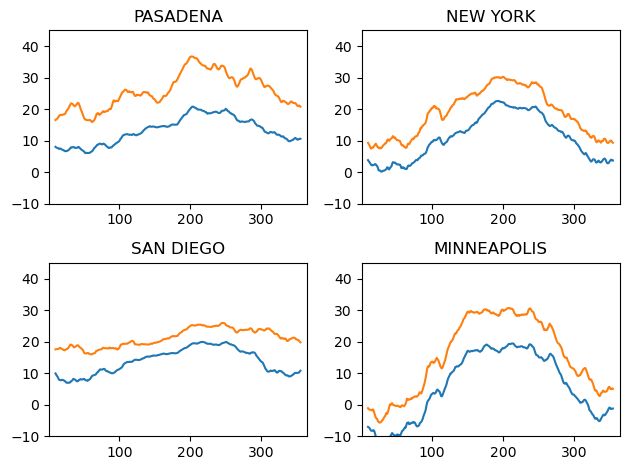

In [229]:
for i, city in enumerate(['PASADENA', 'NEW YORK', 'SAN DIEGO', 'MINNEAPOLIS'], start=1):
    pp.subplot(2, 2, i)
    plotsmoothed(city, 2023)

pp.tight_layout() # space out plots correctly